# Яндекс.Книги. Анализ активности.

- Автор: Симуткин М.А.
- Дата: 14.07.25

## Цели и задачи проекта

- Провести A/B-тестирование пользователей сервиса Яндекс.Книги.
- Провести оценку корректности проведения A/B-теста.
- Анализ результата.

## Описание данных


**таблица пользователей из Москвы и Санкт-Петербурга.**  
- `city` — город пользователя;
- `puid` — идентификатор пользователя;
- `hours` — общее количество часов активности (вычисляется по полю hours).  


**таблица участников тестов.**  
Структура файла:
- `user_id` — идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста;
- `device` — устройство, с которого происходила регистрация.  


**архив с одним csv-файлом, в котором собраны события 2020 года.**  
Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии.

## Содержимое проекта

- **Часть 1. Проверка гипотезы в Python и составление аналитической записки:**
    - Цели и задачи проекта
    - Описание данных
    - Загрузка данных и знакомство с ними
    - Проверка гипотезы в Python
    - Аналитическая записка
- **Часть 2. Анализ результатов A/B-тестирования:**
    - Цели исследования
    - Загрузка данных и проверка целостности
    - Оценка корректности проведения теста
    - Оценка результатов проведенного теста

## 1. Загрузка данных и знакомство с ними

In [1]:
#импорт библиотек для дальнейшей работы
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#импорт методов из библиотек
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower

In [3]:
#загрузка данных
df_yandex_book_test = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [4]:
#удаление лишнего индексного столбца
df_yandex_book_test.drop(columns=['Unnamed: 0'], inplace=True)

df_yandex_book_test.head(5)

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


In [5]:
df_yandex_book_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


In [6]:
#удаление дубликатов
print("Количество строк до удаления дубликатов:", len(df_yandex_book_test))
df_yandex_book_test = df_yandex_book_test.drop_duplicates(subset=['puid'])
print("Количество строк после удаления дубликатов:", len(df_yandex_book_test))

Количество строк до удаления дубликатов: 8784
Количество строк после удаления дубликатов: 8540


In [7]:
#описательная статистика
display(df_yandex_book_test['hours'].describe())

count    8540.000000
mean       10.984603
std        37.677623
min         0.000018
25%         0.059927
50%         0.909128
75%         5.970493
max       978.764775
Name: hours, dtype: float64

In [8]:
#количество пользователей по городам
display(df_yandex_book_test['city'].value_counts())

Москва             6234
Санкт-Петербург    2306
Name: city, dtype: int64

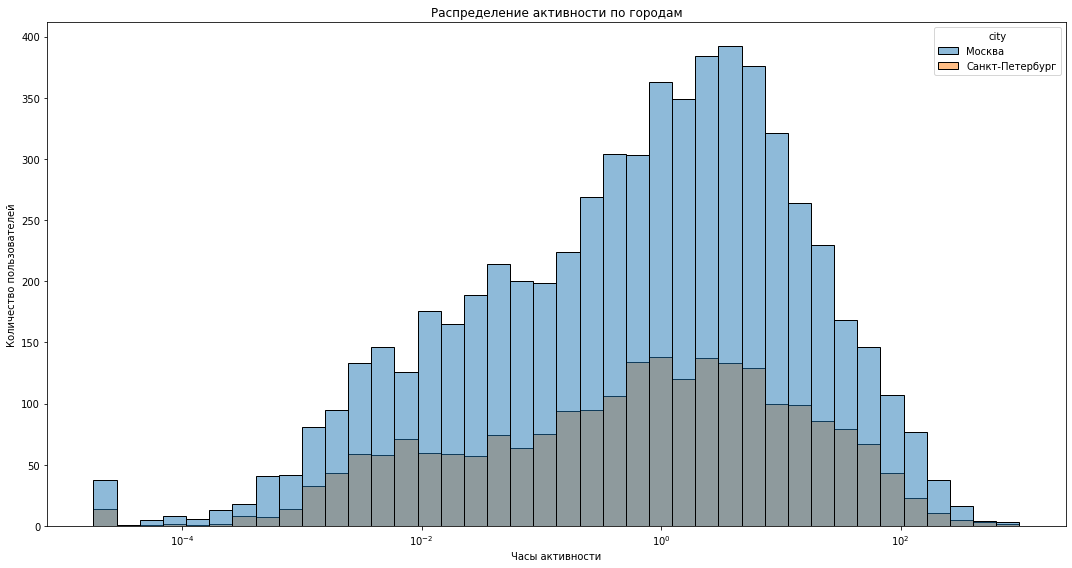

In [9]:
#график распределения активности
plt.figure(figsize=(15, 8))

sns.histplot(data=df_yandex_book_test, 
             x='hours', 
             hue='city', 
             bins=40, 
             log_scale=True)

plt.title('Распределение активности по городам')
plt.xlabel('Часы активности')
plt.ylabel('Количество пользователей')

plt.tight_layout()
plt.show()

**Вывод:**
- Удаленно 244 дубликата в данных
- Большое стандартное отклонение по часовой активности - правосторонняя асимметрия.
- Количество пользователей по городам различается в более, чем 2 раза.

## 2. Проверка гипотезы в Python

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [10]:
#фильтрация групп
user_spb = df_yandex_book_test[df_yandex_book_test['city'] == 'Санкт-Петербург']['hours']
user_msk = df_yandex_book_test[df_yandex_book_test['city'] == 'Москва']['hours']

In [11]:
#односторонний тест Манна-Уитни
u_stat, p_val = mannwhitneyu(user_spb, user_msk, alternative='greater')  # 'greater' — односторонняя гипотеза

alpha = 0.05

print(f'p-value = {p_val:.4f}')

if p_val > alpha:
    print("Нулевая гипотеза. Различий в средней активности нет.")
else:
    print("Альтернативная гипотеза. Средняя активность в Санкт-Петербурге статистически значимо выше.")

p-value = 0.6190
Нулевая гипотеза. Различий в средней активности нет.


## 3. Аналитическая записка

- Выбранный тип теста и уровень статистической значимости.
    - Для проверки гипотезы был использован непараметрический тест Манна-Уитни(U-test)
    - Нет предположения о нормальном распределении данных(распределение правосторонне)
    - Данный тип теста устойчив к выбросам, присутствующих в данных
    - Уровень значимости = 0.05

- Результат теста, или p-value.
    - p-value = 0.6190

- Вывод на основе полученного p-value, то есть интерпретацию результатов.
    - Нулевая гипотеза. Различий в средней активности пользователей между Москвой и Санкт-Петербургом нет.

- Возможные причины:
    - Пользователи в обоих случаях - жители крупных мегаполисов с высоким уровнем доступности интернета, цифровой инфраструктурой, развитой культурой.



----

# Часть 2. Анализ результатов A/B-тестирования

## Цели исследования.

- Провести A/B-тестирование старого и нового интерфейса интернет-магазина BitMotion Kit.
- Провести оценку результатов A/B-теста.
- Анализ результата.

## 2. Загрузка данных

In [12]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [32]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [14]:
display(participants.head())

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [31]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [16]:
display(events.head())

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [34]:
#все уникальные значения в столбце event_name
unique_events = events['event_name'].unique()

display(unique_events)

array(['End of Black Friday Ads Campaign', 'registration', 'product_page',
       'login', 'product_cart', 'purchase',
       'Start of Christmas&New Year Promo',
       'Start of CIS New Year Gift Lottery'], dtype=object)

**Вывод:**
- `participants` - данные полные и соответсвуют описанию.
- `events` - пропуски в малозначимом столбце `details`, данные соответсуют описанию.

## 3. По таблице `ab_test_participants` оцениваем корректность проведения теста:

- соответствие требованиям технического задания,
- равномерность распределения пользователей по группам теста,
- отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [18]:
#смотрим пересечение групп
user_group_counts = participants.groupby('user_id')['group'].nunique()
overlapping_users = user_group_counts[user_group_counts > 1]

if not overlapping_users.empty:
    print(f"Найдено {len(overlapping_users)} пользователей, участвующих в нескольких группах.")
    
    #удаляем таких пользователей из таблицы
    filtered_participants = participants[
        ~participants['user_id'].isin(overlapping_users.index)]
    print(f"Удалено {len(overlapping_users)} пользователей с пересечениями.")
else:
    print("Пересечений между группами нет. Таблица корректна.")
    filtered_participants = participants.copy()

Найдено 446 пользователей, участвующих в нескольких группах.
Удалено 446 пользователей с пересечениями.


In [19]:
#фильтрация необходимого теста
filtered_participants = filtered_participants[filtered_participants['ab_test'] == 'interface_eu_test']

In [20]:
print("Количество пользователей до очистки:", len(participants))
print("Количество пользователей после очистки:", len(filtered_participants))

Количество пользователей до очистки: 14525
Количество пользователей после очистки: 10404


3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:  

Оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [21]:
#фильтруем пользователей по нужному событию
filtered_events = events[events['user_id'].isin(filtered_participants['user_id'])]

print("Количество событий до фильтрации:", len(events))
print("Количество событий после фильтрации:", len(filtered_events))

Количество событий до фильтрации: 787286
Количество событий после фильтрации: 76599


In [22]:
group_distribution = filtered_participants.groupby('group')['user_id'].count()
print("Распределение пользователей по группам:")
print(group_distribution)

Распределение пользователей по группам:
group
A    5277
B    5127
Name: user_id, dtype: int64


**Вывод:**
- В данных имелись дубликаты и пересечения пользователей по группам тестирования
- Создано два датафрейма с фильтрацией `filtered_participants` и `filtered_events`

In [23]:
#найдём дату регистрации для каждого пользователя
registrations = (
    filtered_events[filtered_events['event_name'] == 'registration']
    .groupby('user_id')['event_dt']
    .min()
    .reset_index()
    .rename(columns={'event_dt': 'registration_dt'})
)

#присоединим дату регистрации к таблице событий
filtered_events_with_reg = filtered_events.merge(registrations, on='user_id', how='left')

#рассчитаем разницу между событием и регистрацией
filtered_events_with_reg['days_since_registration'] = (
    filtered_events_with_reg['event_dt'] - filtered_events_with_reg['registration_dt']
).dt.days

#оставим только события, произошедшие в первые 7 дней после регистрации
lifetime_events = filtered_events_with_reg[
    filtered_events_with_reg['days_since_registration'].between(0, 7)
]

#вывод
print("Количество событий до фильтрации по лайфтайму:", len(filtered_events_with_reg))
print("Количество событий после фильтрации:", len(lifetime_events))

Количество событий до фильтрации по лайфтайму: 76599
Количество событий после фильтрации: 68243


In [24]:
## параметры теста
alpha = 0.05 
power = 0.8 #вероятность что нужные мне изменнения найдутся
beta = 1-power #вероятность пропустить нужные мне изменения
p1 = 0.3 #конверсия группы теста `A`
mde = 0.03 #процент изменений, который мы хотит увидеть
p2 = p1 + mde #конверсия для целевой группы `B`

power_analysis = NormalIndPower()
effect_size = (p2 - p1) / np.sqrt((p1*(1-p1) + p2*(1-p2))/2)

#расчёт минимального размера выборки на одну группу
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1
)

#общий объем выборки
total_sample_size = sample_size * 2

print(f"Минимальный размер выборки на группу: {int(sample_size)}")
print(f"Общий размер выборки (A + B): {int(total_sample_size)}")

Минимальный размер выборки на группу: 3759
Общий размер выборки (A + B): 7519


In [25]:
group_distribution = filtered_participants.groupby('group')['user_id'].count()
print(group_distribution)

group
A    5277
B    5127
Name: user_id, dtype: int64


**Вывод:** 
- Количества пользователей для проведения A/B-теста достаточно 
- Группы не имеют сильного количественного различия

In [26]:
#общее количество посетителей в каждой группе
total_users_per_group = filtered_participants.groupby('group')['user_id'].count()
print("Общее количество посетителей:")
print(total_users_per_group)

#количество уникальных пользователей совершивших покупку
purchasing_users = (
    lifetime_events[lifetime_events['event_name'] == 'purchase']
    .groupby('user_id')
    .first()
    .reset_index()
)

#присоединяем информацию о группе из filtered_participants
purchasing_users_with_group = purchasing_users.merge(
    filtered_participants[['user_id', 'group']],
    on='user_id',
    how='left'
)

#количество покупателей по группам
purchasing_users_per_group = purchasing_users_with_group.groupby('group')['user_id'].count()
print("\nКоличество посетителей, совершивших покупку:")
print(purchasing_users_per_group)

#конверсия в покупку
conversion_rate = purchasing_users_per_group / total_users_per_group * 100
print("\nДоля посетителей совершившие покупку (%):")
print(conversion_rate.round(2))

Общее количество посетителей:
group
A    5277
B    5127
Name: user_id, dtype: int64

Количество посетителей, совершивших покупку:
group
A    1515
B    1584
Name: user_id, dtype: int64

Доля посетителей совершившие покупку (%):
group
A    28.71
B    30.90
Name: user_id, dtype: float64


**Предварительный вывод по результатам A/B-теста:**
- `Целостность данных:`  
В данных были обнаружены пересечения пользователей между группами (446 пользователей участвовали одновременно в нескольких тестах).  
Эти пользователи были удалены для чистоты анализа.  
После фильтрации осталось 10 404 пользователей в тесте interface_eu_test (5 277 в группе A и 5 127 в группе B).

- `Распределение пользователей:`  
Группы A и B распределены практически равномерно (разница в ~150 пользователей), что приемлемо для A/B-теста.

- `Длительность анализа:`  
События анализировались в течение первых 7 дней после регистрации пользователя.  
Это позволило исключить долгосрочные эффекты и сосредоточиться на immediate impact изменений.

- `Достаточность выборки:`  
Для заданных параметров (конверсия 30%, мощность 80%, достоверность 95%) минимальный размер выборки на группу должен быть 3759 пользователя.   
В нашем случае размер групп (~ 5 тыс.) достаточен для обнаружения эффекта в 3% (MDE).

- `Конверсия в покупку:`  
Группа A (контрольная): 28.71% пользователей совершили покупку.  
Группа B (тестовая): 30.90% пользователей совершили покупку.  
Разница между группами составляет 2.19 процентных пункта в пользу тестовой группы.

- `Статистическая значимость:`  
Без проведения статистического теста (например, z-теста) нельзя утверждать, что разница значима.  
Однако визуально наблюдается положительный тренд в тестовой группе.

## 4. Проведите оценку результатов A/B-тестирования:

Гипотеза A/B-тестирования:  
- **H0:** Конверсия покупки в группах A и B одинакова.
- **H1:** Конверсия покупки в группе B выше, чем в группе А.

In [27]:
#получаем количество пользователей в каждой группе
total_users = filtered_participants.groupby('group')['user_id'].count()
#получаем количество пользователей, совершивших покупку в каждой группе
purchased_users = purchasing_users_with_group.groupby('group')['user_id'].count()

In [28]:
#создаем переменные для расчета конверсий
n_B = total_users['B']
x_B = purchased_users['B']

n_A = total_users['A']
x_A = purchased_users['A']

#расчёт конверсий
p_B = x_B / n_B
p_A = x_A / n_A
diff = p_B - p_A

#вывод результатов
print(f"Конверсия в группе B: {p_B:.4f} ({p_B*100:.2f}%)")
print(f"Конверсия в группе A: {p_A:.4f} ({p_A*100:.2f}%)")
print(f"Разница конверсий: {diff:.4f} ({diff*100:.2f} п.п.)")

Конверсия в группе B: 0.3090 (30.90%)
Конверсия в группе A: 0.2871 (28.71%)
Разница конверсий: 0.0219 (2.19 п.п.)


In [29]:
#Z-тест для пропорций
count = np.array([x_B, x_A])  # Успехи в группах (B, A)
nobs = np.array([n_B, n_A])   # Общее количество в группах (B, A)
z_score, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print("\nРезультаты Z-теста:")
print(f"Z-статистика: {z_score:.4f}")
print(f"p-value: {p_value:.4f}")

#доверительный интервал
se = np.sqrt(p_A * (1 - p_A) / n_A + p_B * (1 - p_B) / n_B)
ci_low = diff - 1.96 * se
ci_high = diff + 1.96 * se

print(f"\n95% доверительный интервал разницы конверсий: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"Или в процентных пунктах: [{ci_low*100:.2f}%, {ci_high*100:.2f}%]")

#проверка значимости
alpha = 0.05

if p_value < alpha:
    print("\nH1: Конверсия покупки в группе B выше, чем в группе А. (p < 0.05)")
else:
    print("\nH0: Конверсия покупки в группах A и B одинакова. (p ≥ 0.05)")


Результаты Z-теста:
Z-статистика: 2.4373
p-value: 0.0148

95% доверительный интервал разницы конверсий: [0.0043, 0.0394]
Или в процентных пунктах: [0.43%, 3.94%]

H1: Конверсия покупки в группе B выше, чем в группе А. (p < 0.05)


**Выводы по результатам A/B-тестирования:**

- `Статистическая значимость:`  
p-value = 0.0148 (< 0.05), что позволяет отвергнуть нулевую гипотезу (H0) о равенстве конверсий.  
Z-статистика = 2.44 (превышает критическое значение для α = 0.05), подтверждая значимость различий.  
95% доверительный интервал разницы конверсий: [0.43%, 3.94%] не включает ноль, что также указывает на значимость.  

- `Эффект изменений:`  
Конверсия в группе B (30.90%) оказалась выше, чем в группе A (28.71%).  
Абсолютный прирост конверсии: +2.19 процентных пункта.  
Относительный прирост: (30.90% / 28.71%) - 1 ≈ 7.6%.  

- `Достаточность выборки:`  
Объём выборки достаточен для обнаружения эффекта в 3% (MDE)

- `Практическая значимость:`  
Улучшение конверсии на 7.6% — существенный результат для бизнеса, особенно если масштабировать его на всех пользователей.  
Однако необходимо учесть:
Короткий горизонт анализа (7 дней): долгосрочный эффект может отличаться.

- `Рекомендации:`  
Внедрить изменения для всех пользователей, так как новый интерфейс показал улучшение конверсии.  
Так как наблюдаемый эффект (2.19п.п.) меньше MDE,но все равно оказался статистически значимым, стоит рассмотреть возможность дальнейшей оптимизации интерфейса , чтобы усилить эффект и достичь целевых значений MDE.